In [92]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

### Data Exploration

In [93]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
print(df)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign    y

In [94]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [95]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


In [96]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


### Data cleaning

1- Check for missing values

In [98]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

No missing values are present

2- Checking outliers

(array([1.6120e+03, 1.1462e+04, 1.0133e+04, 8.3760e+03, 5.5840e+03,
        2.6890e+03, 8.3000e+01, 4.2000e+01, 1.6000e+01, 3.0000e+00]),
 array([19. , 26.6, 34.2, 41.8, 49.4, 57. , 64.6, 72.2, 79.8, 87.4, 95. ]),
 <BarContainer object of 10 artists>)

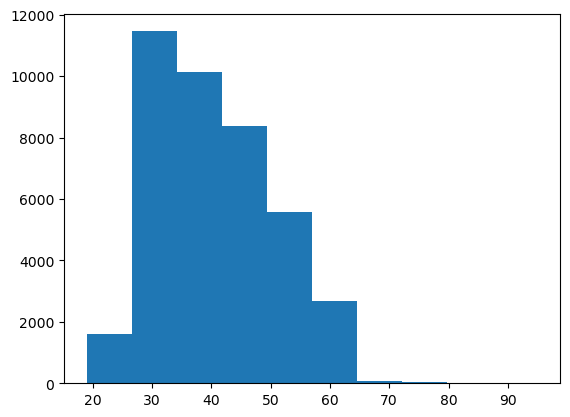

In [99]:
plt.hist(df['age'])

We can see that the majority of people have age between 30 and 40 with few samples between 20 and 30 and even less samples greater tha 65 (outliers)

(array([3.5363e+04, 4.3170e+03, 2.4600e+02, 4.4000e+01, 1.8000e+01,
        5.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ -8019. ,   2995.6,  14010.2,  25024.8,  36039.4,  47054. ,
         58068.6,  69083.2,  80097.8,  91112.4, 102127. ]),
 <BarContainer object of 10 artists>)

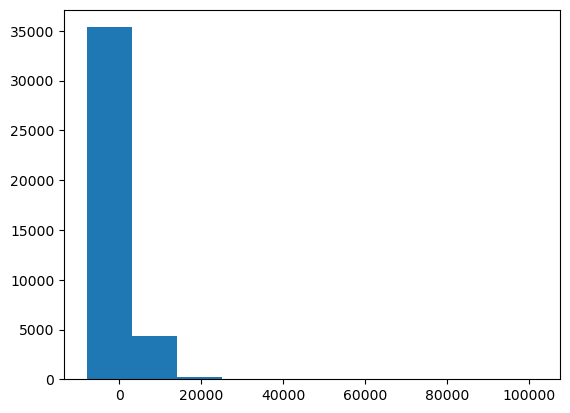

In [100]:
plt.hist(df['balance'])

The majority of the people have the balance in the range negative balance and approximately 18000 wiith very few samples near 20000 and greater(outliers)

(array([2159., 4652., 4606., 2925., 4429., 5200., 6219., 1948., 2564.,
        5298.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

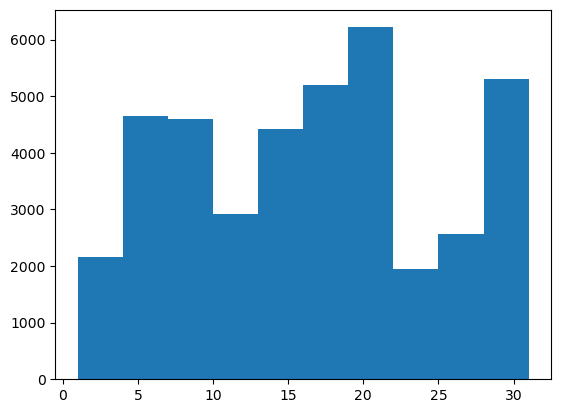

In [101]:
plt.hist(df['day'])

(array([3.5137e+04, 3.8610e+03, 7.8300e+02, 1.5800e+02, 3.7000e+01,
        1.1000e+01, 1.1000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  491.8,  983.6, 1475.4, 1967.2, 2459. , 2950.8, 3442.6,
        3934.4, 4426.2, 4918. ]),
 <BarContainer object of 10 artists>)

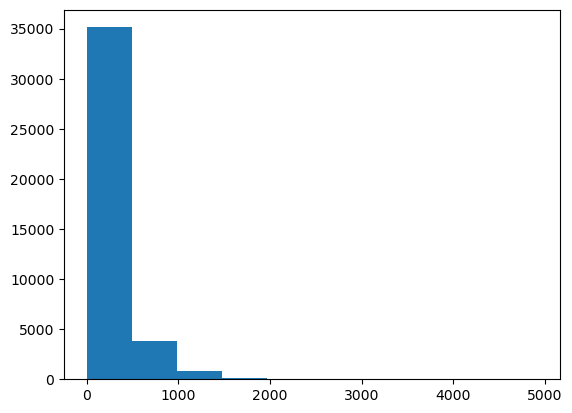

In [102]:
plt.hist(df['duration'])

The duration of the last contact seems to be in the range of 500 seconds for most people. There are few samples with duration between 500 and 1000 seconds and very rarely the last contance seems to exceed 1000 seconds(outliers)

(array([3.7707e+04, 1.5880e+03, 4.1800e+02, 1.6500e+02, 7.5000e+01,
        3.3000e+01, 7.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ]),
 <BarContainer object of 10 artists>)

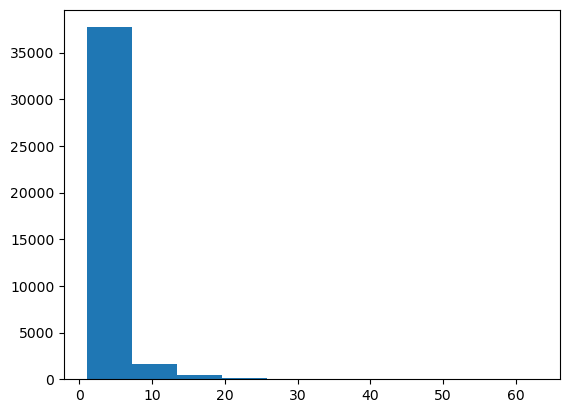

In [103]:
plt.hist(df['campaign'])

The number of contacts performed during this campaign seems to be approximately between one and 8 for most client rarely exceeding 13(outliers).

### Visualize data and features engineering

C:\Users\PicardiC\AppData\Local\Temp\ipykernel_7664\1015742225.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


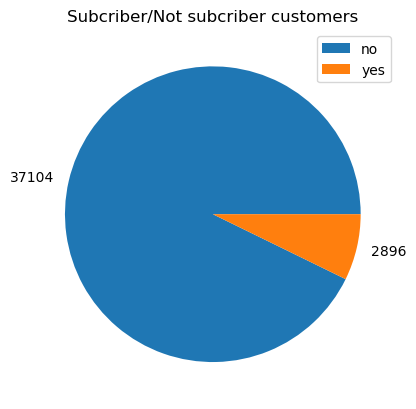

In [104]:
fig, ax = plt.subplots()
subscriber_counts = df['y'].value_counts()
ax.pie(subscriber_counts, labels=subscriber_counts)
ax.set_title('Subcriber/Not subcriber customers')
ax.legend(subscriber_counts.keys().tolist())
fig.show()

In [105]:
df['y']=pd.factorize(df['y'])[0]

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [107]:
df_sub = df[df.y==1]
df_sub.shape

(2896, 14)

In [108]:
df_not_sub = df[df.y==0]
df_not_sub.shape

(37104, 14)

The data are unbalanced with only 2896 subscriber aganist 37104 non subscriber. We need to remember this in the classification task.

#### Age

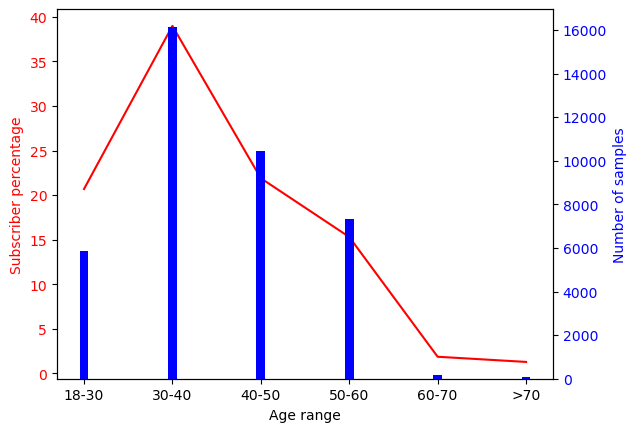

In [109]:
label = ['18-30','30-40','40-50','50-60','60-70','>70']
perc_age = [round((df_sub[(18 <= df_sub['age']) & (df_sub['age'] <= 30)]).shape[0]/df_sub.shape[0]*100,2),round((df_sub[(30 < df_sub['age']) & (df_sub['age'] <= 40)]).shape[0]/df_sub.shape[0]*100,2),round((df_sub[(40 < df_sub['age']) & (df_sub['age'] <= 50)]).shape[0]/df_sub.shape[0]*100,2),round((df_sub[(50 < df_sub['age']) & (df_sub['age'] <= 60)]).shape[0]/df_sub.shape[0]*100,2),round((df_sub[(60 < df_sub['age']) & (df_sub['age'] <= 70)]).shape[0]/df_sub.shape[0]*100,2),round((df_sub[(df_sub['age'] > 70)]).shape[0]/df_sub.shape[0]*100,2)]
num_samp_age = [(df[(18 <= df['age']) & (df['age'] <= 30)]).shape[0],(df[(30 < df['age']) & (df['age'] <= 40)]).shape[0],(df[(40 < df['age']) & (df['age'] <= 50)]).shape[0],(df[(50 < df['age']) & (df['age'] <= 60)]).shape[0],(df[(60 < df['age']) & (df['age'] <= 70)]).shape[0],(df[(df['age'] > 70)]).shape[0]]
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel("Age range") 
ax1.set_ylabel('Subscriber percentage', color = 'red') 
ax1.plot(label,perc_age, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Number of samples', color = 'blue') 
ax2.bar(label,num_samp_age,width=0.1, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

The subscriber percentage increase from the range 18-30 to the range 30-40 where the most samples are. After that it progressively decreases making the feature not correlated with the target.

#### Job

In [110]:
print(df['job'].unique()) 

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


In [111]:
print(df['job'].value_counts()) 

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64


Givent the number of categories and samples it would be better to merge categories together. The categories unemployed, housemaid, student, unknown, retired and self-employed will be grouped together in the category 'Not full-time job'. The categories admin, technician, services will be grouped together in the category 'Office job' and the categories entrepreneur, management, blue-collar will be grouped together in the category 'High profile job'.

In [113]:
d = {'technician':'office job','admin':'office job','services':'office job','unemployed':'not full-time job','housemaid':'not full-time job','student':'not full-time job','unknown':'not full-time job','retired':'not full-time job','self-employed':'not full-time job','entrepreneur':'high profile job','management':'high profile job','blue-collar':'high profile job'}
df['job'] = df['job'].replace(d)
df_sub['job'] = df_sub['job'].replace(d)
df_not_sub['job'] = df_not_sub['job'].replace(d)

C:\Users\PicardiC\AppData\Local\Temp\ipykernel_7664\2856525914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['job'] = df_sub['job'].replace(d)
C:\Users\PicardiC\AppData\Local\Temp\ipykernel_7664\2856525914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_sub['job'] = df_not_sub['job'].replace(d)


In [114]:
print(df['job'].unique()) 
print(df_sub['job'].unique())
print(df_not_sub['job'].unique())


['high profile job' 'office job' 'not full-time job']
['office job' 'high profile job' 'not full-time job']
['high profile job' 'office job' 'not full-time job']


In [115]:
print(df['job'].value_counts()) 

high profile job     18954
office job           15245
not full-time job     5801
Name: job, dtype: int64


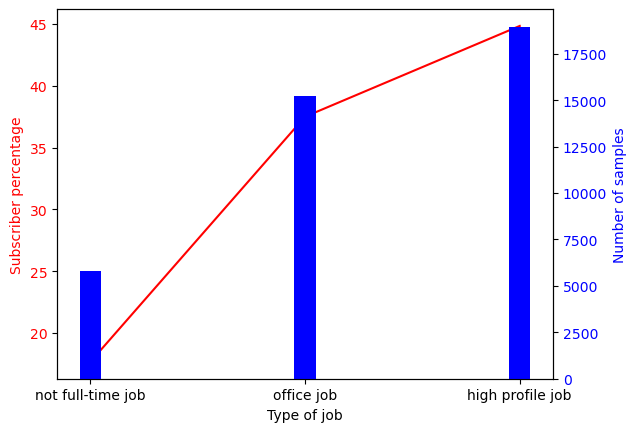

In [116]:
label = ['not full-time job','office job', 'high profile job']
perc_job = [round((df_sub[df_sub.job=='not full-time job']).shape[0]/df_sub.shape[0]*100,2),round((df_sub[df_sub.job=='office job']).shape[0]/df_sub.shape[0]*100,2),round((df_sub[df_sub.job=='high profile job']).shape[0]/df_sub.shape[0]*100,2)]
num_samp_job = [df[df.job=='not full-time job'].shape[0], df[df.job=='office job'].shape[0], df[df.job=='high profile job'].shape[0]]
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel("Type of job") 
ax1.set_ylabel('Subscriber percentage', color = 'red') 
ax1.plot(label,perc_job, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Number of samples', color = 'blue') 
ax2.bar(label,num_samp_job,width=0.1, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

As expected the percentage of subscriber grow when the job position improve. This feature seems to have influence on the target.

#### Marital

In [117]:
print(df['marital'].unique()) 

['married' 'single' 'divorced']


In [118]:
print(df['marital'].value_counts()) 

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64


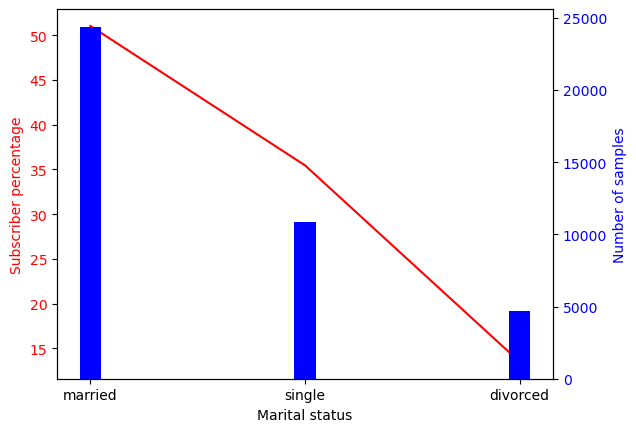

In [119]:
label = ['married','single', 'divorced']
perc_mar = [round((df_sub[df_sub.marital=='married']).shape[0]/df_sub.shape[0]*100,2),round((df_sub[df_sub.marital=='single']).shape[0]/df_sub.shape[0]*100,2),round((df_sub[df_sub.marital=='divorced']).shape[0]/df_sub.shape[0]*100,2)]
num_samp_mar = [df[df.marital=='married'].shape[0], df[df.marital=='single'].shape[0], df[df.marital=='divorced'].shape[0]]
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel("Marital status") 
ax1.set_ylabel('Subscriber percentage', color = 'red') 
ax1.plot(label,perc_mar, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Number of samples', color = 'blue') 
ax2.bar(label,num_samp_mar,width=0.1, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

The greatest subscriber percentage is in the married people decreasing drastically in divorced people. The reason of this could be related to desire to build a new family or just a random case due to the sample size.

#### Education

In [120]:
print(df['education'].unique()) 

['tertiary' 'secondary' 'unknown' 'primary']


In [ ]:
label = ['primary', 'secondary', 'tertiary', 'unknown']
perc_ed = []